In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras

### **Visualising Images**

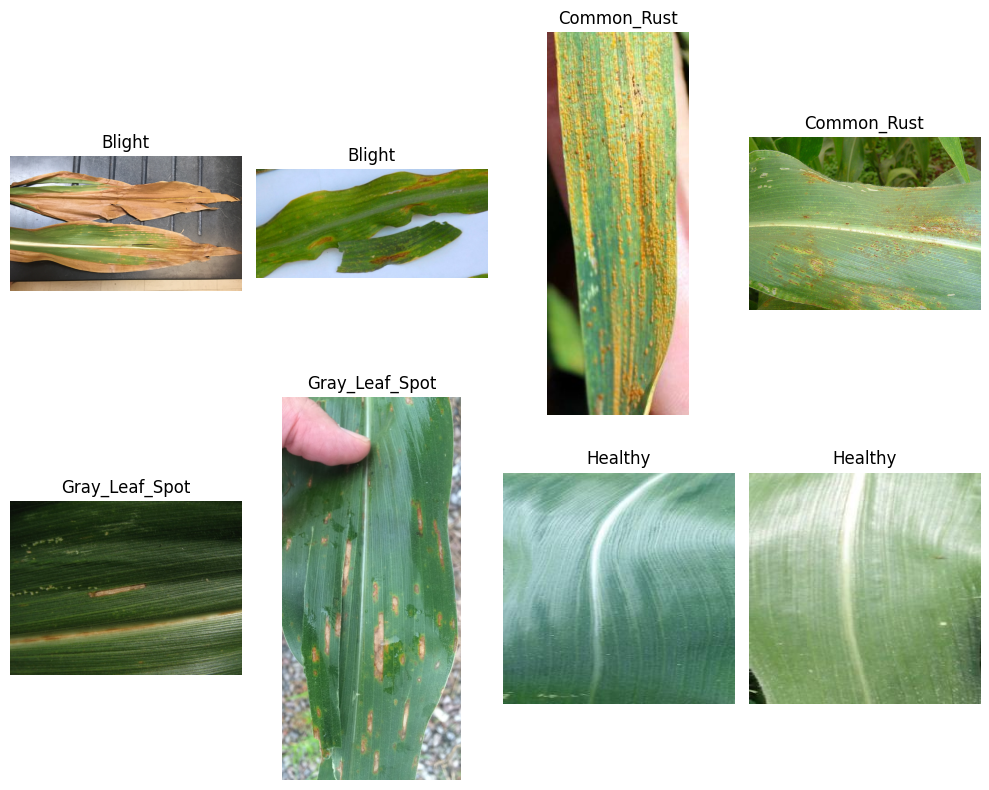

In [2]:
# Define dataset directory
path = r'maize-leaf-dataset'

# Define categories (subdirectories)
categories = ["Blight", "Common_Rust", "Gray_Leaf_Spot", "Healthy"]

# Collect 2 images from each category
images = []
image_labels = []

for category in categories:
    category_path = os.path.join(path, category)
    if os.path.exists(category_path):  # Ensure the directory exists
        image_files = os.listdir(category_path)[:2]  # Pick first 2 images
        for img in image_files:
            images.append(os.path.join(category_path, img))
            image_labels.append(category)

# Visualizing images
plt.figure(figsize=(10, 8))
for i, img_path in enumerate(images):  # Show all selected images
    img = plt.imread(img_path)
    plt.subplot(2, 4, i + 1)  # 2 rows, 4 columns (8 images total)
    plt.imshow(img)
    plt.title(image_labels[i])
    plt.axis("off")

plt.tight_layout()
plt.show()

### **Data preparation**

Checking for corrupt images and filtering them out

In [3]:
dataset_path = r'maize-leaf-dataset'

def is_image_corrupted(image_path):
    """
    Check if an image is corrupted by attempting to decode it.
    """
    try:
        image = tf.io.read_file(image_path)
        image = tf.image.decode_image(image, channels=3)  # Try to decode as RGB image
        return False  # Image is not corrupted
    except:
        return True  # Image is corrupted

def filter_corrupted_images(dataset_path):
    """
    Filter out corrupted images from the dataset.
    """
    corrupted_images = []
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                if is_image_corrupted(image_path):
                    corrupted_images.append(image_path)
                    os.remove(image_path)  # Remove the corrupted image
    return corrupted_images

# Filter out corrupted images
corrupted_images = filter_corrupted_images(dataset_path)
print(f"Removed {len(corrupted_images)} corrupted images.")

Removed 0 corrupted images.


Split images from the source directory into training and validation sets.

In [4]:
# Load training dataset (80%)
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,  # 20% will be split into validation and testing
    subset="training",
    seed=123,
    batch_size=None  # Disable automatic batching
)

# Load validation + test dataset (20%)
val_test_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,  # 20% will be further split into validation and testing
    subset="validation",
    seed=123,
    batch_size=None  # Disable automatic batching
)

# Further split validation and test (10% each)
val_size = int(0.5 * len(val_test_ds))  # Half for validation
test_size = len(val_test_ds) - val_size  # Remaining half for testing

val_ds = val_test_ds.take(val_size)  # Take first half as validation set
test_ds = val_test_ds.skip(val_size)  # Skip first half, use remaining as test set

Found 4566 files belonging to 4 classes.
Using 3653 files for training.
Found 4566 files belonging to 4 classes.
Using 913 files for validation.


Since the sizes of our images are all different, we need to convert them all to the same size. We can create a function that will do that for us below.

In [5]:
IMG_SIZE = 160  # Resize all images to 160x160

def format_example(image, label):
    """
    Resizes the image to IMG_SIZE and normalizes pixel values to [-1, 1].
    """
    image = tf.cast(image, tf.float32)  # Convert to float32
    image = (image / 127.5) - 1  # Normalize to [-1, 1] range
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))  # Resize image
    return image, label


# we can apply this function to all our images using .map().
train_ds = train_ds.map(format_example)
val_ds = val_ds.map(format_example)
test_ds = test_ds.map(format_example)

Finally we will shuffle and batch the images.

In [6]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train_ds.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_batches = val_ds.batch(BATCH_SIZE)
test_batches = test_ds.batch(BATCH_SIZE)

Now if we look at the shape of an original image vs the new image we will see it has been changed.

In [7]:
# Take 2 samples from the original dataset (before resizing)
for img, label in train_batches.unbatch().take(2):  
    print("Original shape:", img.shape)

# Take 2 samples from the processed dataset (after resizing & batching)
for img, label in train_batches.take(2):  
    print("New shape:", img.shape)

Original shape: (160, 160, 3)
Original shape: (160, 160, 3)
New shape: (32, 160, 160, 3)
New shape: (32, 160, 160, 3)


### **CNN Architecture**


In [19]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

In [20]:
# Load MobileNet V2 as the base model
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


In [21]:
# Freezing the Base
base_model.trainable = False

In [22]:
# Adding our classifier
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [23]:
# Adding the prediction Layer
prediction_layer = keras.layers.Dense(4, activation="softmax")


In [24]:
# Now we will combine these layers together in a model.
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_________________________________________________________________


In [26]:
'''
import tensorflow_hub as hub

# Define the image size
image_size = (150, 150)  # Replace with your desired image size

# Load EfficientNetV2 model from TensorFlow Hub
efficient_net = hub.KerasLayer(
    "https://www.kaggle.com/models/google/efficientnet-v2/frameworks/TensorFlow2/variations/imagenet21k-b3-feature-vector/versions/1",
    trainable=False  # Freeze the base model
)

# Define the input shape
inputs = keras.Input(shape=(image_size[0], image_size[1], 3))

# Pass inputs through the EfficientNetV2 model
x = efficient_net(inputs)

# Add custom dense layers on top of the base model
x = keras.layers.Flatten()(x)  # Flatten the output
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(6, activation='softmax')(x)  # 6 classes

# Build the final model
model = keras.Model(inputs, outputs)

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Use 'sparse_categorical_crossentropy' if labels are integers
    metrics=['accuracy']
)

'''

'\nimport tensorflow_hub as hub\n\n# Define the image size\nimage_size = (150, 150)  # Replace with your desired image size\n\n# Load EfficientNetV2 model from TensorFlow Hub\nefficient_net = hub.KerasLayer(\n    "https://www.kaggle.com/models/google/efficientnet-v2/frameworks/TensorFlow2/variations/imagenet21k-b3-feature-vector/versions/1",\n    trainable=False  # Freeze the base model\n)\n\n# Define the input shape\ninputs = keras.Input(shape=(image_size[0], image_size[1], 3))\n\n# Pass inputs through the EfficientNetV2 model\nx = efficient_net(inputs)\n\n# Add custom dense layers on top of the base model\nx = keras.layers.Flatten()(x)  # Flatten the output\nx = keras.layers.Dense(512, activation=\'relu\')(x)\nx = keras.layers.BatchNormalization()(x)\nx = keras.layers.Dropout(0.5)(x)\nx = keras.layers.Dense(256, activation=\'relu\')(x)\nx = keras.layers.BatchNormalization()(x)\nx = keras.layers.Dropout(0.3)(x)\nx = keras.layers.Dense(128, activation=\'relu\')(x)\nx = keras.layers.Bat

### **Training**

In [29]:
base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  
              metrics=['accuracy'])

In [30]:
# Now we can train it on our images
history = model.fit(train_batches,
                    epochs=10,
                    validation_data=val_batches)

acc = history.history['accuracy']
print(acc)

Epoch 1/10
115/115 [==============================] - 47s 285ms/step - loss: 1.0598 - accuracy: 0.5746 - val_loss: 0.6640 - val_accuracy: 0.7675
Epoch 2/10
115/115 [==============================] - 39s 276ms/step - loss: 0.5389 - accuracy: 0.7996 - val_loss: 0.4848 - val_accuracy: 0.8268
Epoch 3/10
115/115 [==============================] - 39s 269ms/step - loss: 0.3948 - accuracy: 0.8519 - val_loss: 0.3709 - val_accuracy: 0.8575
Epoch 4/10
115/115 [==============================] - 41s 289ms/step - loss: 0.3337 - accuracy: 0.8771 - val_loss: 0.3325 - val_accuracy: 0.8706
Epoch 5/10
115/115 [==============================] - 42s 278ms/step - loss: 0.2973 - accuracy: 0.8897 - val_loss: 0.2861 - val_accuracy: 0.8904
Epoch 6/10
115/115 [==============================] - 45s 291ms/step - loss: 0.2731 - accuracy: 0.8987 - val_loss: 0.2862 - val_accuracy: 0.8969
Epoch 7/10
115/115 [==============================] - 42s 289ms/step - loss: 0.2548 - accuracy: 0.9069 - val_loss: 0.2624 - val_ac